# Naive Bayes

## Introduction

We will start by working on the Iris dataset. Recall that Iris dataset contains iris species and sepal and petal measurements. We will quickly explore the dataset and jump into Naive Bayes.

In [1]:
from __future__ import print_function
import os
#Data Path has to be set as per the file location in your system
#data_path = ['..', 'data']
data_path = ['C:\\data']

## Question 1

* Load the Iris dataset.
* Take a quick look at the data types.
* Look at the skew values and decide if any transformations need to be applied. You can use skew value 0.75 as a threshold.
* Use `sns.pairplot` to plot the pairwise correlations and histograms. Use `hue="species"` as a keyword argument in order to see the distribution of species.

In [2]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell 
filepath = os.sep.join(data_path + ['Wine_Quality_Data.csv'])
data = pd.read_csv(filepath, sep=',', header=0)

In [3]:
data.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
color                    object
dtype: object

Notice that aside from the predictor variable, everything is float.

In [4]:
#데이터의 편향성 체크 0.75로 체크
skew = pd.DataFrame(data.skew())
skew.columns = ['skew']
skew['too_skewed'] = skew['skew'] > .75
skew

,skew,too_skewed
fixed_acidity,1.723290,True
volatile_acidity,1.495097,True
citric_acid,0.471731,False
residual_sugar,1.435404,True
chlorides,5.399828,True
free_sulfur_dioxide,1.220066,True
total_sulfur_dioxide,-0.001177,False
density,0.503602,False
pH,0.386839,False
sulphates,1.797270,True


Fields are not too badly skewed.

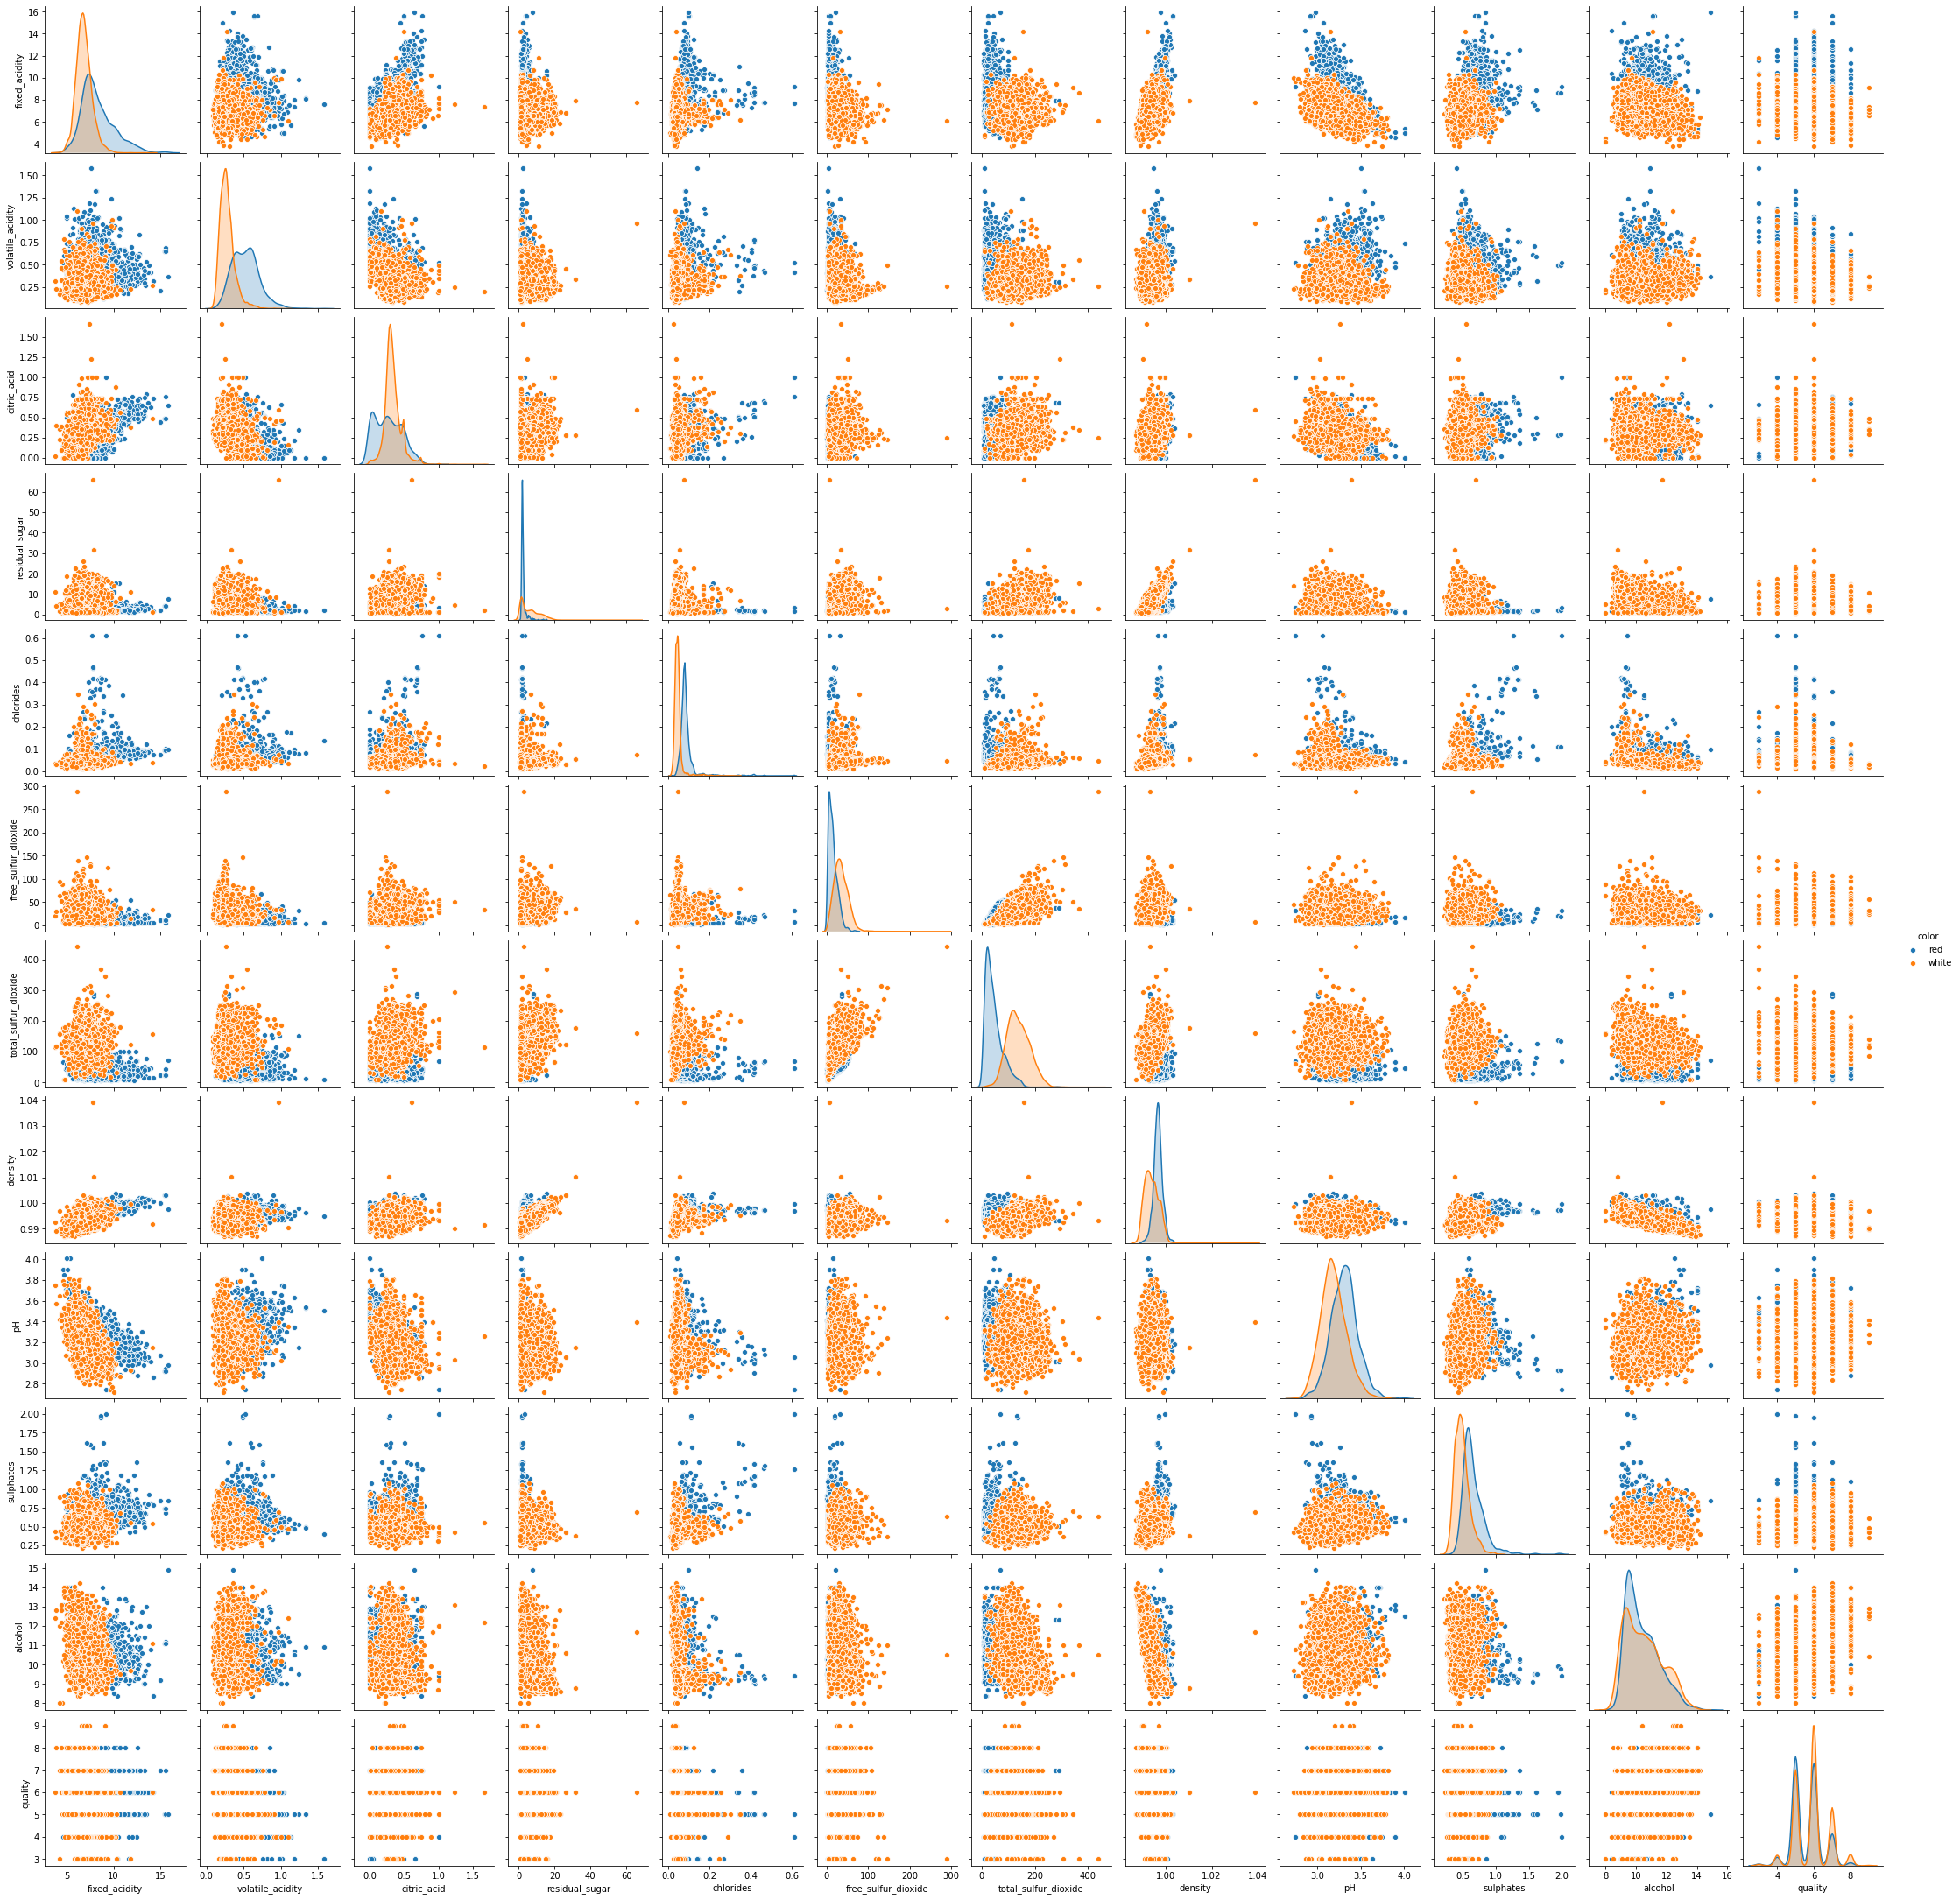

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.pairplot(data, hue='color')

## Question 2

Let's now fit a Naive Bayes classifier to this data in order to predict "species".

* Pick the appropriate type of Naive Bayes given the nature of your dataset (data types of columns). Recall, choices are
    * GaussianNB
    * MultinomialNB
    * BernoulliNB
* Use `cross_val_score` to see how well your choice works.

In [9]:
# Since the features are continuous, the right choice is GaussianNB

from sklearn.naive_bayes import GaussianNB
#cross_val_score이 kfold해서 결과값까지 표출
from sklearn.model_selection import cross_val_score
X = data[data.columns[:-1]]
y = data.color

GNB = GaussianNB()
cv_N = 4       # k값
scores = cross_val_score(GNB, X, y, cv=cv_N)
print(scores)
np.mean(scores)

[0.96492308 0.96736453 0.97536946 0.97105911]


0.9696790450928381

## Question 3:

Now let's try all types of Naive Bayes and observe what happens

* Compare the cross validation scores for Gaussian, Bernouilli and Multinomial Naive Bayes.
* Why is BernoulliNB performing like it does?

In [11]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
X = data[data.columns[:-1]]     #맨 뒤 컬럼은 보통 y니깐 마지막 전까지 x로
y = data.color
nb = {'gaussian': GaussianNB(),
      'bernoulli': BernoulliNB(),
      'multinomial': MultinomialNB()}
scores = {}
#items로 접근
for key, model in nb.items():
    s = cross_val_score(model, X, y, cv=cv_N, scoring='accuracy')
    #성능
    scores[key] = np.mean(s)
scores
#베르누이 이유: 바이너리 환경이여서 확률 찍는거 보다 낮게나옴

{'gaussian': 0.9696790450928381,
 'bernoulli': 0.7712792724516861,
 'multinomial': 0.9207340848806366}

Looks like BernoulliNB results are very bad, but MultinomialNB is doing a very good job.

Why are the results of Bernoulli bad? Find out the reason.

## Question 4:

Let's see what happens when we take away the predictive features.

* Check the pairplot histograms (diagonal) you produced above and identify the two most predictive features visually.
* Remove the *petal_* features which are very predictive, and re-do the comparison above. That is, get the cross validation scores for all types of Naive Bayes.

In [12]:
#petal의 분포가 그래프에서 떨어져있어서 이거 빼고 해보기
# 편향성 False만 해보기
X = data[['total_sulfur_dioxide', 'density', 'pH','alcohol','quality']]
y = data.color

nb = {'gaussian': GaussianNB(),
      'bernoulli': BernoulliNB(),
      'multinomial': MultinomialNB()}

scores = {}
for key, model in nb.items():
    s = cross_val_score(model, X, y, cv=cv_N, n_jobs=cv_N, scoring='accuracy')
    scores[key] = np.mean(s)
scores

{'gaussian': 0.9555214096248579,
 'bernoulli': 0.7538864153088292,
 'multinomial': 0.9056504357711255}

#Come up with your observations after taking away the very predictive features, which model works better

## Question 5

This question explores how Naive Bayes algorithms can be affected when we push the underlying (naive) assumption too much. Recall that the naive assumption is that the features in the training set are *independent* from each other.

* Create **0, 1, 3, 5, 10, 50, 100** copies of `sepal_length` and fit a `GaussianNB` for each one.
* Keep track of the save the average `cross_val_score`.
* Create a plot of the saved scores over the number of copies.

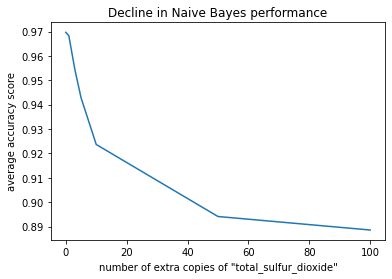

In [15]:
#특징 갯수 sepal_length 늘리면서 성능 체크
X = data[data.columns[:-1]]
y = data.color

n_copies = [0, 1, 3, 5, 10, 50, 100]


def create_copies_sepal_length(X, n):
    X_new = X.copy()
    for i in range(n):
        X_new['total_sulfur_dioxide_copy%s' % i] = X['total_sulfur_dioxide']
    return X_new


def get_cross_val_score(n):
    X_new = create_copies_sepal_length(X, n)
    scores = cross_val_score(GaussianNB(), X_new, y, cv=cv_N, n_jobs=cv_N)
    return np.mean(scores)


avg_scores = pd.Series(
    [get_cross_val_score(n) for n in n_copies],
    index=n_copies)

ax = avg_scores.plot()
ax.set(
    xlabel='number of extra copies of "total_sulfur_dioxide"',
    ylabel='average accuracy score',
    title='Decline in Naive Bayes performance');
#길이 증가할 수록 성능 하락 -> 특징간 독립이 가정이여서 늘어났을때 성능 하락